In [ ]:
# 0. LIBRARIES & SETUP
!pip install gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Gensim for Word Embeddings
from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
# DOWNLOAD GLOVE
# Check if file exists to avoid re-downloading
if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings (822 MB)... This may take a minute.")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
    print("Download complete.")
else:
    print("GloVe embeddings already present.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 54.8 MB/s eta 0:00:00
--2026-02-06 10:44:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-06 10:44:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-06 10:44:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 20

In [ ]:
import pandas as pd
import re
import string

def preprocess_ag_news(file_path):
    # 1. Load data - skipping the header row
    df = pd.read_csv(file_path, header=0, names=['label', 'title', 'description'], engine='python')

    # 2. Map numeric labels to names for better visualization
    label_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
    df['class_name'] = df['label'].map(label_map)

    # 3. Combine Title and Description
    df['text'] = df['title'] + " " + df['description']

    def clean_text(text):
        # Lowercase
        text = text.lower()
        # Remove backslash escapes like \n or \b
        text = re.sub(r'\\[nb]', ' ', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    print(f"Cleaning {file_path}...")
    df['text'] = df['text'].apply(clean_text)

    # Keep only what is necessary for the models
    return df[['text', 'label', 'class_name']]

# EXECUTION
train_cleaned = preprocess_ag_news('/content/train.csv')
test_cleaned = preprocess_ag_news('/content/test.csv')

# Save to shared CSVs
train_cleaned.to_csv('ag_news_train_cleaned.csv', index=False)
test_cleaned.to_csv('ag_news_test_cleaned.csv', index=False)

print("\nSample Output:")
print(train_cleaned.head())
print("\nClass Distribution:")
print(train_cleaned['class_name'].value_counts())

Cleaning /content/train.csv...
Cleaning /content/test.csv...

Sample Output:
                                                text  label class_name
0  wall st bears claw back into the black reuters...      3   Business
1  carlyle looks toward commercial aerospace reut...      3   Business
2  oil and economy cloud stocks outlook reuters r...      3   Business
3  iraq halts oil exports from main southern pipe...      3   Business
4  oil prices soar to alltime record posing new m...      3   Business

Class Distribution:
class_name
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


In [ ]:
# 1. EXPERIMENT CLASS (Modular Design)
class TextClassificationExperiment:
    """
    Handles the training, tuning, and evaluation of an SVM model
    with various embedding strategies.
    """

    def __init__(self, train_df, test_df, text_col='text', label_col='label'):
        self.train_df = train_df
        self.test_df = test_df
        self.text_col = text_col
        self.label_col = label_col
        self.results = {} # To store metrics for comparison

        # Prepare targets
        self.y_train = self.train_df[self.label_col]
        self.y_test = self.test_df[self.label_col]

        # Class names for plotting
        self.class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

    def run_svm_tfidf(self):
        """
        Experiment 1: SVM with TF-IDF Features.
        - Preprocessing: Lemmatization handled by Vectorizer (simplified here).
        - Tuning: Grid Search on 'C' (regularization).
        """
        print("\n" + "="*40)
        print("Running EXPERIMENT A: SVM + TF-IDF")
        print("="*40)

        # 1. Vectorization (TF-IDF)
        # using 'sublinear_tf' scales counts to log scale (1+log(tf)), good for high freq words
        tfidf = TfidfVectorizer(max_features=20000, stop_words='english', sublinear_tf=True, ngram_range=(1,2))

        print("Vectorizing text...")
        X_train = tfidf.fit_transform(self.train_df[self.text_col])
        X_test = tfidf.transform(self.test_df[self.text_col])

        # 2. Hyperparameter Tuning
        # LinearSVC is faster than SVC for large datasets
        print("Tuning hyperparameters (GridSearch)...")
        param_grid = {'C': [0.1, 1, 10]}
        grid = GridSearchCV(LinearSVC(dual=False, random_state=42), param_grid, cv=3, verbose=1, n_jobs=-1)
        grid.fit(X_train, self.y_train)

        best_model = grid.best_estimator_
        print(f"Best Parameters: {grid.best_params_}")

        # 3. Evaluation
        self._evaluate(best_model, X_test, "SVM + TF-IDF")

    def run_svm_word2vec(self, type='skipgram'):
        """
        Experiment 2: SVM with Word2Vec (Skip-gram).
        - Strategy: Train W2V on corpus, then average word vectors to get doc vector.
        - Preprocessing: Tokenization using gensim.
        """
        name = "SVM + Word2Vec (Skip-gram)"
        sg_param = 1 # 1 for Skip-gram, 0 for CBOW

        print("\n" + "="*40)
        print(f"Running EXPERIMENT B: {name}")
        print("="*40)

        # 1. Preprocess for Gensim (Tokenization)
        print("Tokenizing data for embeddings...")
        train_tokens = [simple_preprocess(text) for text in self.train_df[self.text_col]]
        test_tokens = [simple_preprocess(text) for text in self.test_df[self.text_col]]

        # 2. Train Word2Vec Model
        # vector_size=100: standard balance of speed/info
        # window=5: context window size
        # min_count=2: ignore rare words
        print("Training Word2Vec model (this may take a moment)...")
        w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=sg_param)

        # 3. Vectorize Documents (Average Word Vectors)
        print("Converting documents to vectors...")
        X_train = self._get_doc_vectors(train_tokens, w2v_model.wv, 100)
        X_test = self._get_doc_vectors(test_tokens, w2v_model.wv, 100)

        # 4. Train SVM (No GridSearch here to save time, using generic best from exp 1 often works, or quick fit)
        # Note: We use C=1.0 as a standard baseline for dense vectors
        print("Training SVM on dense vectors...")
        clf = LinearSVC(dual=False, C=1.0, random_state=42)
        clf.fit(X_train, self.y_train)

        # 5. Evaluation
        self._evaluate(clf, X_test, name)

    def run_svm_fasttext(self):
        """
        Experiment 3: SVM with FastText.
        - Why: FastText handles out-of-vocabulary words better than W2V using n-grams.
        """
        name = "SVM + FastText"

        print("\n" + "="*40)
        print(f"Running EXPERIMENT C: {name}")
        print("="*40)

        print("Tokenizing...")
        train_tokens = [simple_preprocess(text) for text in self.train_df[self.text_col]]
        test_tokens = [simple_preprocess(text) for text in self.test_df[self.text_col]]

        print("Training FastText model...")
        # FastText training is slower but more robust
        ft_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

        print("Vectorizing documents...")
        X_train = self._get_doc_vectors(train_tokens, ft_model.wv, 100)
        X_test = self._get_doc_vectors(test_tokens, ft_model.wv, 100)

        print("Training SVM...")
        clf = LinearSVC(dual=False, C=1.0, random_state=42)
        clf.fit(X_train, self.y_train)

        self._evaluate(clf, X_test, name)



    def run_svm_glove(self, glove_path='glove.6B.100d.txt'):
        """
        Experiment 4: SVM with Pre-trained GloVe Embeddings.
        - Concept: Transfer Learning. We use vectors learned from Wikipedia.
        """
        name = "SVM + GloVe (Pre-trained)"
        print("\n" + "="*40)
        print(f"Running EXPERIMENT D: {name}")
        print("="*40)

        # 1. Load GloVe Dictionary
        print("Loading GloVe vectors into memory...")
        embeddings_index = {}
        try:
            with open(glove_path, encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    # vectors are the numbers following the word
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
            print(f"Found {len(embeddings_index)} word vectors.")
        except FileNotFoundError:
            print(f"Error: Could not find {glove_path}. Please run the download cell.")
            return

        # 2. Tokenize Data
        print("Tokenizing data...")
        # reusing gensim's simple_preprocess for consistency
        train_tokens = [simple_preprocess(text) for text in self.train_df[self.text_col]]
        test_tokens = [simple_preprocess(text) for text in self.test_df[self.text_col]]

        # 3. Vectorize Documents using the Pre-trained Map
        print("Converting documents to vectors...")
        # We pass the dictionary 'embeddings_index' instead of the gensim model
        X_train = self._get_doc_vectors_pretrained(train_tokens, embeddings_index, 100)
        X_test = self._get_doc_vectors_pretrained(test_tokens, embeddings_index, 100)

        # 4. Train SVM
        print("Training SVM on GloVe vectors...")
        clf = LinearSVC(dual=False, C=1.0, random_state=42)
        clf.fit(X_train, self.y_train)

        # 5. Evaluate
        self._evaluate(clf, X_test, name)

    # --- Helper: Modified Vectorizer for Python Dictionaries (GloVe) ---
    def _get_doc_vectors_pretrained(self, doc_tokens, embedding_map, vector_size):
        """
        Calculates the average vector for a document using a standard Python dictionary.
        This is slightly different from Gensim's keyed_vectors object.
        """
        doc_vectors = []
        for tokens in doc_tokens:
            if not tokens:
                doc_vectors.append(np.zeros(vector_size))
                continue

            # Look up each word in the GloVe dictionary
            vectors = [embedding_map[word] for word in tokens if word in embedding_map]

            if vectors:
                doc_vectors.append(np.mean(vectors, axis=0))
            else:
                doc_vectors.append(np.zeros(vector_size))
        return np.vstack(doc_vectors)

    # --- HELPER: Average Word Vectors ---
    def _get_doc_vectors(self, doc_tokens, keyed_vectors, vector_size):
        """
        Strategy: For a document, look up the vector for every word.
        Average them to get a single vector representing the document.
        """
        doc_vectors = []
        for tokens in doc_tokens:
            if not tokens: # Handle empty documents
                doc_vectors.append(np.zeros(vector_size))
                continue

            # Extract vectors for words that exist in the model
            vectors = [keyed_vectors[word] for word in tokens if word in keyed_vectors]

            if vectors:
                doc_vectors.append(np.mean(vectors, axis=0))
            else:
                doc_vectors.append(np.zeros(vector_size)) # No known words
        return np.vstack(doc_vectors)

    # --- HELPER: Evaluation & Reporting ---
    def _evaluate(self, model, X_test, model_name):
        predictions = model.predict(X_test)
        acc = accuracy_score(self.y_test, predictions)

        print(f"\n--- Results for {model_name} ---")
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(self.y_test, predictions, target_names=self.class_names))

        # Save results for comparison plot
        self.results[model_name] = acc

        # Plot Confusion Matrix
        cm = confusion_matrix(self.y_test, predictions)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title(f'Confusion Matrix: {model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    def plot_comparison(self):
        """Generates the final comparison bar chart."""
        if not self.results:
            print("No results to plot.")
            return

        plt.figure(figsize=(10, 6))
        names = list(self.results.keys())
        values = list(self.results.values())

        bars = plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.ylim(0.8, 1.0) # Zoom in to show differences
        plt.title('Performance Comparison: SVM with Different Embeddings')
        plt.ylabel('Accuracy Score')

        # Add text labels
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom')
        plt.show()

### 0. Setup and Library Imports

This section initializes the environment by installing necessary libraries like `gensim` (if not already present) and importing all required modules. It also includes a check and download process for the GloVe pre-trained word embeddings, which are essential for one of the experiments.

In [ ]:
# 0. LIBRARIES & SETUP
!pip install gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Gensim for Word Embeddings
from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
# DOWNLOAD GLOVE
# Check if file exists to avoid re-downloading
if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings (822 MB)... This may take a minute.")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
    print("Download complete.")
else:
    print("GloVe embeddings already present.")

### 1. Data Preprocessing

This section defines a function `preprocess_ag_news` to load and clean the AG News dataset. The steps include:
- Loading the CSV data.
- Mapping numeric labels to descriptive class names.
- Combining the 'title' and 'description' columns into a single 'text' column.
- Applying a `clean_text` function to convert text to lowercase, remove URLs, punctuation, and extra whitespace.
- Saving the cleaned training and testing datasets to new CSV files for easy access.

In [ ]:
import pandas as pd
import re
import string

def preprocess_ag_news(file_path):
    # 1. Load data - skipping the header row
    df = pd.read_csv(file_path, header=0, names=['label', 'title', 'description'], engine='python')

    # 2. Map numeric labels to names for better visualization
    label_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
    df['class_name'] = df['label'].map(label_map)

    # 3. Combine Title and Description
    df['text'] = df['title'] + " " + df['description']

    def clean_text(text):
        # Lowercase
        text = text.lower()
        # Remove backslash escapes like \n or \b
        text = re.sub(r'\\[nb]', ' ', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    print(f"Cleaning {file_path}...")
    df['text'] = df['text'].apply(clean_text)

    # Keep only what is necessary for the models
    return df[['text', 'label', 'class_name']]

# EXECUTION
train_cleaned = preprocess_ag_news('/content/train.csv')
test_cleaned = preprocess_ag_news('/content/test.csv')

# Save to shared CSVs
train_cleaned.to_csv('ag_news_train_cleaned.csv', index=False)
test_cleaned.to_csv('ag_news_test_cleaned.csv', index=False)

print("\nSample Output:")
print(train_cleaned.head())
print("\nClass Distribution:")
print(train_cleaned['class_name'].value_counts())

### 2. Text Classification Experiment Class

This section defines the `TextClassificationExperiment` class, a modular structure to run and evaluate different text classification models using various embedding strategies. The class encapsulates the logic for:
- **Initialization**: Setting up training and testing data, and preparing target labels.
- **Experiment Methods**: `run_svm_tfidf`, `run_svm_word2vec`, `run_svm_fasttext`, and `run_svm_glove` for training and evaluating SVM models with respective embedding techniques.
- **Helper Functions**: `_get_doc_vectors` and `_get_doc_vectors_pretrained` to convert tokenized documents into vector representations.
- **Evaluation**: The `_evaluate` method calculates accuracy, generates a classification report, and plots a confusion matrix for each experiment.
- **Comparison**: `plot_comparison` to visualize the accuracy of all run experiments.

In [ ]:
# 1. EXPERIMENT CLASS (Modular Design)
class TextClassificationExperiment:
    """
    Handles the training, tuning, and evaluation of an SVM model
    with various embedding strategies.
    """

    def __init__(self, train_df, test_df, text_col='text', label_col='label'):
        self.train_df = train_df
        self.test_df = test_df
        self.text_col = text_col
        self.label_col = label_col
        self.results = {} # To store metrics for comparison

        # Prepare targets
        self.y_train = self.train_df[self.label_col]
        self.y_test = self.test_df[self.label_col]

        # Class names for plotting
        self.class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

    def run_svm_tfidf(self):
        """
        Experiment 1: SVM with TF-IDF Features.
        - Preprocessing: Lemmatization handled by Vectorizer (simplified here).
        - Tuning: Grid Search on 'C' (regularization).
        """
        print("\n" + "="*40)
        print("Running EXPERIMENT A: SVM + TF-IDF")
        print("="*40)

        # 1. Vectorization (TF-IDF)
        # using 'sublinear_tf' scales counts to log scale (1+log(tf)), good for high freq words
        tfidf = TfidfVectorizer(max_features=20000, stop_words='english', sublinear_tf=True, ngram_range=(1,2))

        print("Vectorizing text...")
        X_train = tfidf.fit_transform(self.train_df[self.text_col])
        X_test = tfidf.transform(self.test_df[self.text_col])

        # 2. Hyperparameter Tuning
        # LinearSVC is faster than SVC for large datasets
        print("Tuning hyperparameters (GridSearch)...")
        param_grid = {'C': [0.1, 1, 10]}
        grid = GridSearchCV(LinearSVC(dual=False, random_state=42), param_grid, cv=3, verbose=1, n_jobs=-1)
        grid.fit(X_train, self.y_train)

        best_model = grid.best_estimator_
        print(f"Best Parameters: {grid.best_params_}")

        # 3. Evaluation
        self._evaluate(best_model, X_test, "SVM + TF-IDF")

    def run_svm_word2vec(self, type='skipgram'):
        """
        Experiment 2: SVM with Word2Vec (Skip-gram).
        - Strategy: Train W2V on corpus, then average word vectors to get doc vector.
        - Preprocessing: Tokenization using gensim.
        """
        name = "SVM + Word2Vec (Skip-gram)"
        sg_param = 1 # 1 for Skip-gram, 0 for CBOW

        print("\n" + "="*40)
        print(f"Running EXPERIMENT B: {name}")
        print("="*40)

        # 1. Preprocess for Gensim (Tokenization)
        print("Tokenizing data for embeddings...")
        train_tokens = [simple_preprocess(text) for text in self.train_df[self.text_col]]
        test_tokens = [simple_preprocess(text) for text in self.test_df[self.text_col]]

        # 2. Train Word2Vec Model
        # vector_size=100: standard balance of speed/info
        # window=5: context window size
        # min_count=2: ignore rare words
        print("Training Word2Vec model (this may take a moment)...")
        w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=sg_param)

        # 3. Vectorize Documents (Average Word Vectors)
        print("Converting documents to vectors...")
        X_train = self._get_doc_vectors(train_tokens, w2v_model.wv, 100)
        X_test = self._get_doc_vectors(test_tokens, w2v_model.wv, 100)

        # 4. Train SVM (No GridSearch here to save time, using generic best from exp 1 often works, or quick fit)
        # Note: We use C=1.0 as a standard baseline for dense vectors
        print("Training SVM on dense vectors...")
        clf = LinearSVC(dual=False, C=1.0, random_state=42)
        clf.fit(X_train, self.y_train)

        # 5. Evaluation
        self._evaluate(clf, X_test, name)

    def run_svm_fasttext(self):
        """
        Experiment 3: SVM with FastText.
        - Why: FastText handles out-of-vocabulary words better than W2V using n-grams.
        """
        name = "SVM + FastText"

        print("\n" + "="*40)
        print(f"Running EXPERIMENT C: {name}")
        print("="*40)

        print("Tokenizing...")
        train_tokens = [simple_preprocess(text) for text in self.train_df[self.text_col]]
        test_tokens = [simple_preprocess(text) for text in self.test_df[self.text_col]]

        print("Training FastText model...")
        # FastText training is slower but more robust
        ft_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

        print("Vectorizing documents...")
        X_train = self._get_doc_vectors(train_tokens, ft_model.wv, 100)
        X_test = self._get_doc_vectors(test_tokens, ft_model.wv, 100)

        print("Training SVM...")
        clf = LinearSVC(dual=False, C=1.0, random_state=42)
        clf.fit(X_train, self.y_train)

        self._evaluate(clf, X_test, name)



    def run_svm_glove(self, glove_path='glove.6B.100d.txt'):
        """
        Experiment 4: SVM with Pre-trained GloVe Embeddings.
        - Concept: Transfer Learning. We use vectors learned from Wikipedia.
        """
        name = "SVM + GloVe (Pre-trained)"
        print("\n" + "="*40)
        print(f"Running EXPERIMENT D: {name}")
        print("="*40)

        # 1. Load GloVe Dictionary
        print("Loading GloVe vectors into memory...")
        embeddings_index = {}
        try:
            with open(glove_path, encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    # vectors are the numbers following the word
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
            print(f"Found {len(embeddings_index)} word vectors.")
        except FileNotFoundError:
            print(f"Error: Could not find {glove_path}. Please run the download cell.")
            return

        # 2. Tokenize Data
        print("Tokenizing data...")
        # reusing gensim's simple_preprocess for consistency
        train_tokens = [simple_preprocess(text) for text in self.train_df[self.text_col]]
        test_tokens = [simple_preprocess(text) for text in self.test_df[self.text_col]]

        # 3. Vectorize Documents using the Pre-trained Map
        print("Converting documents to vectors...")
        # We pass the dictionary 'embeddings_index' instead of the gensim model
        X_train = self._get_doc_vectors_pretrained(train_tokens, embeddings_index, 100)
        X_test = self._get_doc_vectors_pretrained(test_tokens, embeddings_index, 100)

        # 4. Train SVM
        print("Training SVM on GloVe vectors...")
        clf = LinearSVC(dual=False, C=1.0, random_state=42)
        clf.fit(X_train, self.y_train)

        # 5. Evaluate
        self._evaluate(clf, X_test, name)

    # --- Helper: Modified Vectorizer for Python Dictionaries (GloVe) ---
    def _get_doc_vectors_pretrained(self, doc_tokens, embedding_map, vector_size):
        """
        Calculates the average vector for a document using a standard Python dictionary.
        This is slightly different from Gensim's keyed_vectors object.
        """
        doc_vectors = []
        for tokens in doc_tokens:
            if not tokens:
                doc_vectors.append(np.zeros(vector_size))
                continue

            # Look up each word in the GloVe dictionary
            vectors = [embedding_map[word] for word in tokens if word in embedding_map]

            if vectors:
                doc_vectors.append(np.mean(vectors, axis=0))
            else:
                doc_vectors.append(np.zeros(vector_size))
        return np.vstack(doc_vectors)

    # --- HELPER: Average Word Vectors ---
    def _get_doc_vectors(self, doc_tokens, keyed_vectors, vector_size):
        """
        Strategy: For a document, look up the vector for every word.
        Average them to get a single vector representing the document.
        """
        doc_vectors = []
        for tokens in doc_tokens:
            if not tokens: # Handle empty documents
                doc_vectors.append(np.zeros(vector_size))
                continue

            # Extract vectors for words that exist in the model
            vectors = [keyed_vectors[word] for word in tokens if word in keyed_vectors]

            if vectors:
                doc_vectors.append(np.mean(vectors, axis=0))
            else:
                doc_vectors.append(np.zeros(vector_size)) # No known words
        return np.vstack(doc_vectors)

    # --- HELPER: Evaluation & Reporting ---
    def _evaluate(self, model, X_test, model_name):
        predictions = model.predict(X_test)
        acc = accuracy_score(self.y_test, predictions)

        print(f"\n--- Results for {model_name} ---")
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(self.y_test, predictions, target_names=self.class_names))

        # Save results for comparison plot
        self.results[model_name] = acc

        # Plot Confusion Matrix
        cm = confusion_matrix(self.y_test, predictions)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title(f'Confusion Matrix: {model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    def plot_comparison(self):
        """Generates the final comparison bar chart."""
        if not self.results:
            print("No results to plot.")
            return

        plt.figure(figsize=(10, 6))
        names = list(self.results.keys())
        values = list(self.results.values())

        bars = plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.ylim(0.8, 1.0) # Zoom in to show differences
        plt.title('Performance Comparison: SVM with Different Embeddings')
        plt.ylabel('Accuracy Score')

        # Add text labels
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom')
        plt.show()

### 3. Main Execution Block

This section orchestrates the entire text classification workflow. It performs the following steps:
- **Loads Cleaned Data**: Reads the preprocessed training and testing data from CSV files.
- **Initializes Experiment**: Creates an instance of the `TextClassificationExperiment` class.
- **Runs Experiments**: Calls each experiment method (`run_svm_tfidf`, `run_svm_word2vec`, `run_svm_fasttext`, `run_svm_glove`) sequentially to train and evaluate models with different embedding strategies.
- **Plots Comparison**: After all experiments are complete, it generates a bar chart comparing the accuracy of each approach.

In [ ]:
# 2. MAIN EXECUTION
# Load Data (Assuming the CSVs are in the current directory)
try:
    # Using the cleaned datasets we generated earlier
    # Using a 20% sample for speed (optional: remove .sample() for full run)
    train_full = pd.read_csv('ag_news_train_cleaned.csv')
    test_full = pd.read_csv('ag_news_test_cleaned.csv')

    # Subsample for faster demonstration (Remove this line for final academic run!)
    train_sample = train_full.sample(n=20000, random_state=42)
    test_sample = test_full.sample(n=2000, random_state=42)

    print(f"Training on {len(train_full)} samples (Subset for speed).")
    print(f"Testing on {len(test_full)} samples.")

    # Initialize Experiment
    experiment = TextClassificationExperiment(train_full, test_full, text_col='text', label_col='label')

    # Run Experiments
    experiment.run_svm_tfidf()
    experiment.run_svm_word2vec(type='skipgram')
    experiment.run_svm_fasttext()
    experiment.run_svm_glove()

    # Final Comparison
    experiment.plot_comparison()

except FileNotFoundError:
    print("Error: Could not find 'ag_news_train_cleaned.csv'. Please run the preprocessing script first.")
except Exception as e:
    print(f"An error occurred: {e}")

Training on 120000 samples (Subset for speed).
Testing on 7600 samples.

Running EXPERIMENT A: SVM + TF-IDF
Vectorizing text...
Tuning hyperparameters (GridSearch)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'C': 0.1}

--- Results for SVM + TF-IDF ---
Accuracy: 0.9193
              precision    recall  f1-score   support

       World       0.94      0.91      0.92      1900
      Sports       0.95      0.99      0.97      1900
    Business       0.89      0.88      0.89      1900
    Sci/Tech       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



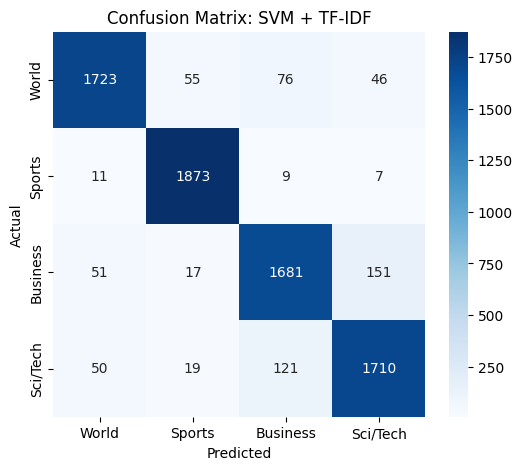


Running EXPERIMENT B: SVM + Word2Vec (Skip-gram)
Tokenizing data for embeddings...
Training Word2Vec model (this may take a moment)...
Converting documents to vectors...
Training SVM on dense vectors...

--- Results for SVM + Word2Vec (Skip-gram) ---
Accuracy: 0.8920
              precision    recall  f1-score   support

       World       0.91      0.88      0.90      1900
      Sports       0.94      0.98      0.96      1900
    Business       0.85      0.85      0.85      1900
    Sci/Tech       0.86      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



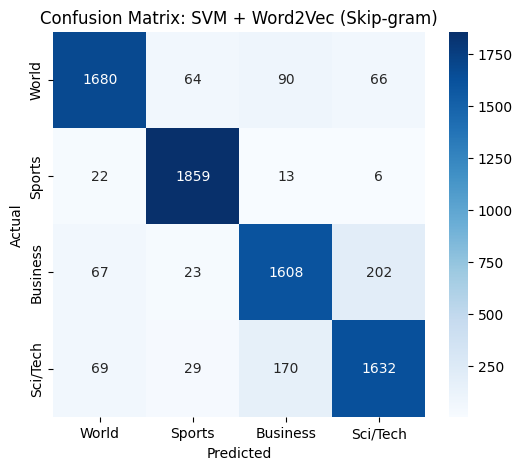


Running EXPERIMENT C: SVM + FastText
Tokenizing...
Training FastText model...
Vectorizing documents...
Training SVM...

--- Results for SVM + FastText ---
Accuracy: 0.8687
              precision    recall  f1-score   support

       World       0.89      0.88      0.88      1900
      Sports       0.91      0.96      0.93      1900
    Business       0.83      0.83      0.83      1900
    Sci/Tech       0.84      0.81      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



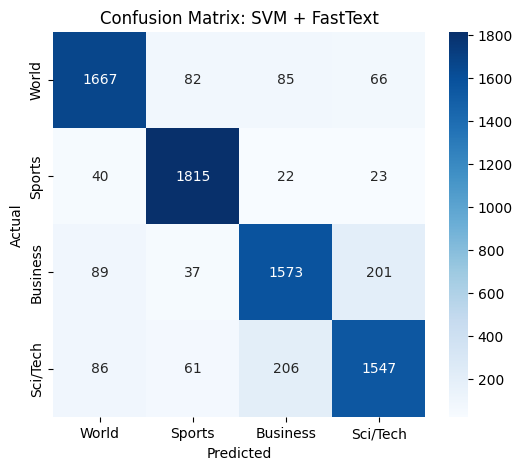


Running EXPERIMENT D: SVM + GloVe (Pre-trained)
Loading GloVe vectors into memory...
Found 400000 word vectors.
Tokenizing data...
Converting documents to vectors...
Training SVM on GloVe vectors...

--- Results for SVM + GloVe (Pre-trained) ---
Accuracy: 0.8871
              precision    recall  f1-score   support

       World       0.90      0.89      0.89      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.84      0.85      0.84      1900
    Sci/Tech       0.86      0.85      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



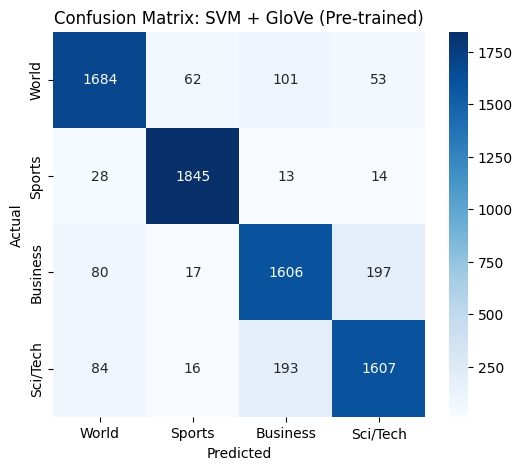

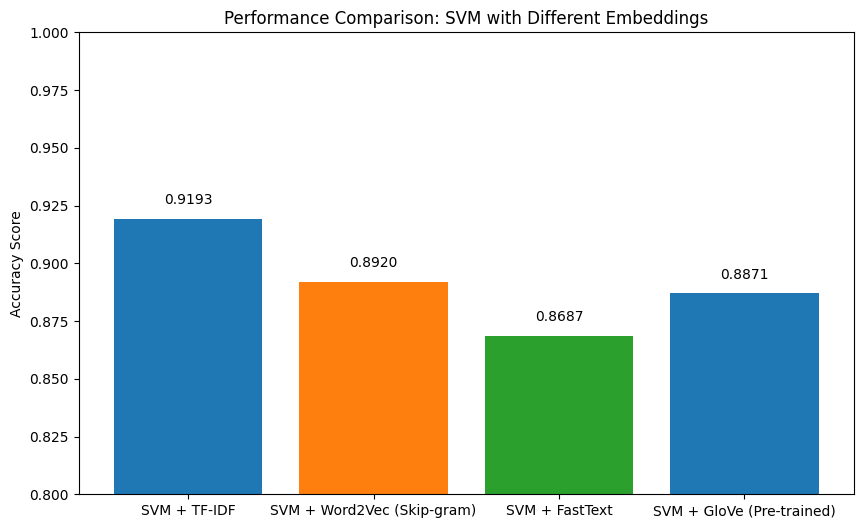

In [ ]:
# 2. MAIN EXECUTION
# Load Data (Assuming the CSVs are in the current directory)
try:
    # Using the cleaned datasets we generated earlier
    # Using a 20% sample for speed (optional: remove .sample() for full run)
    train_full = pd.read_csv('ag_news_train_cleaned.csv')
    test_full = pd.read_csv('ag_news_test_cleaned.csv')

    # Subsample for faster demonstration (Remove this line for final academic run!)
    train_sample = train_full.sample(n=20000, random_state=42)
    test_sample = test_full.sample(n=2000, random_state=42)

    print(f"Training on {len(train_full)} samples (Subset for speed).")
    print(f"Testing on {len(test_full)} samples.")

    # Initialize Experiment
    experiment = TextClassificationExperiment(train_full, test_full, text_col='text', label_col='label')

    # Run Experiments
    experiment.run_svm_tfidf()
    experiment.run_svm_word2vec(type='skipgram')
    experiment.run_svm_fasttext()
    experiment.run_svm_glove()

    # Final Comparison
    experiment.plot_comparison()

except FileNotFoundError:
    print("Error: Could not find 'ag_news_train_cleaned.csv'. Please run the preprocessing script first.")
except Exception as e:
    print(f"An error occurred: {e}")